In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Importing Libraries
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [3]:
#Fetch Images count from Fodlers
import os

count = 0
dirs = os.listdir('/content/drive/MyDrive/Coral Dataset')

for dir in dirs:
    if not dir.startswith('.'):
        dir_path = os.path.join('/content/drive/MyDrive/Coral Dataset', dir)
        files = list(os.listdir(dir_path))
        print(dir + ' Folder has ' + str(len(files)) + ' Images')
        count = count + len(files)

print('Total number of images:', count)

Bleached  Folder has 1084 Images
Black Band Disease Folder has 940 Images
Porites Trematodiasis Folder has 1099 Images
Healthy Folder has 888 Images
Total number of images: 4011


In [4]:
#Load Images into Arrays as Dataset
base_dir = '/content/drive/MyDrive/Coral Dataset'
img_size = 256
batch = 32

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 4011 files belonging to 4 classes.
Using 3209 files for training.
Found 4011 files belonging to 4 classes.
Using 802 files for validation.


In [6]:
coral_types = train_ds.class_names
coral_types

['Black Band Disease', 'Bleached ', 'Healthy', 'Porites Trematodiasis']

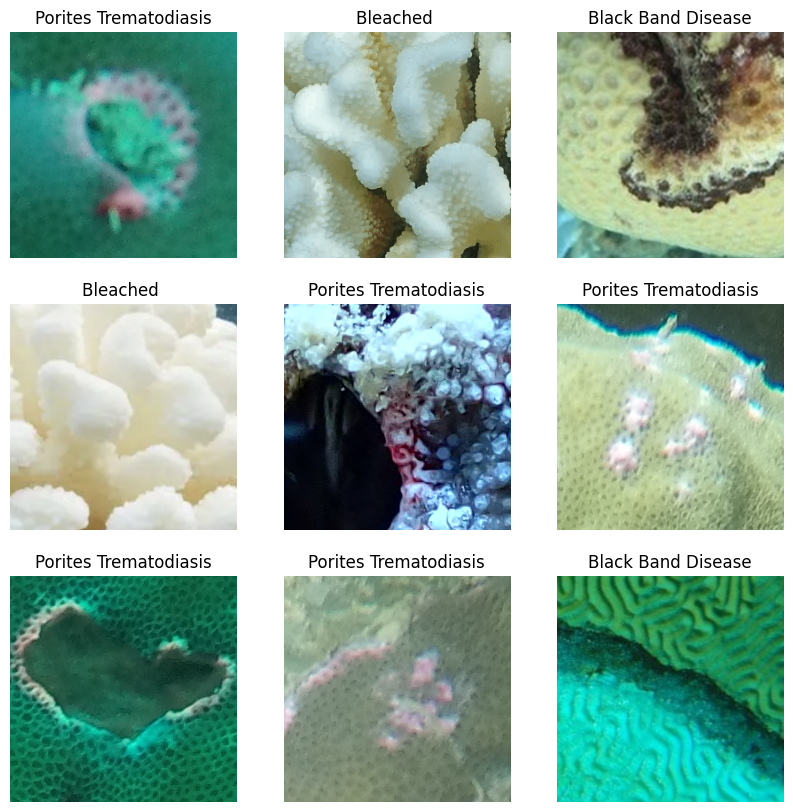

In [7]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(coral_types[labels[i]])
        plt.axis('off')

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [10]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [11]:
#Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


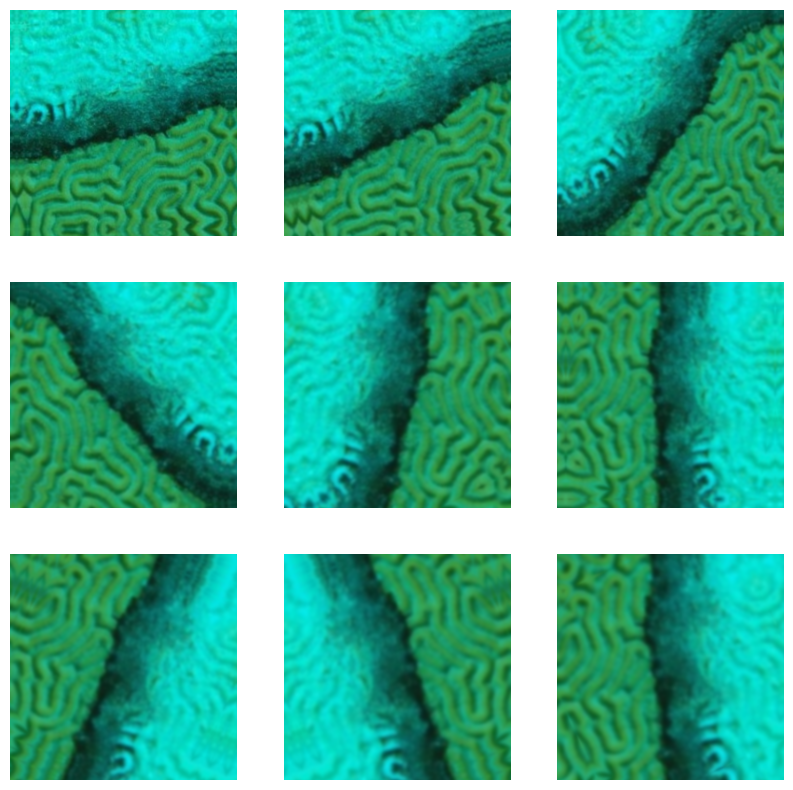

In [12]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [13]:
input_shape = (256, 256, 3)

model = Sequential([
    layers.Input(shape = input_shape),
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,292,517 (16.37 MB)

 Trainable params: 4,292,517 (16.37 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(train_ds, epochs = 15, validation_data = val_ds)

Epoch 1/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 394s 4s/step - accuracy: 0.4843 - loss: 1.1596 - val_accuracy: 0.6883 - val_loss: 0.6293
Epoch 2/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 361s 3s/step - accuracy: 0.7598 - loss: 0.5494 - val_accuracy: 0.8342 - val_loss: 0.4211
Epoch 3/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.8523 - loss: 0.3861 - val_accuracy: 0.8416 - val_loss: 0.3942
Epoch 4/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - accuracy: 0.8535 - loss: 0.3748 - val_accuracy: 0.8953 - val_loss: 0.2700
Epoch 5/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.9068 - loss: 0.2493 - val_accuracy: 0.9190 - val_loss: 0.2282
Epoch 6/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 0.9170 - loss: 0.2097 - val_accuracy: 0.9090 - val_loss: 0.2795
Epoch 7/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.9164 - loss: 0.2248 - val_accuracy: 0.8953 - val_loss: 0.3224
Epoch 8/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.9278 - loss: 0.1906 - val_accu

In [18]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(256,256))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The coral image is ' + coral_types[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [19]:
classify_images('/content/drive/MyDrive/Coral Dataset/Healthy/100.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


'The coral image is Healthy with a score of 99.99575614929199'

In [ ]:
model.save('Coral_Recog_Model.keras')